### Imports

In [2]:
import sys
import numpy as np
import pandas as pd
from fingerprints.get_fp import output, input

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 


import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from plotnine import *

In [3]:
odorants = pd.read_csv('data/odorants.csv')
labels = pd.read_csv('data/labels.csv')
labels_ = labels.set_index("CID").iloc[:, 1:]
solubility = pd.read_csv('data/solubility.csv')

fingerprint = input

# Data prep

In [4]:
odorants.columns, labels.columns, solubility.columns

(Index(['CID', 'MolecularWeight', 'IsomericSMILES', 'IUPACName', 'name',
        'num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
        'num_of_O_atoms', 'num_of_N_atoms', 'PolarA', 'PolarB', 'TopoCharge',
        'VdW', 'AromaticA', 'AromaticB', 'HBondAcceptorCount',
        'HBondDonorCount', 'XLogP', 'TPSA'],
       dtype='object'),
 Index(['CID', 'IsomericSMILES', 'alcoholic', 'aldehydic', 'alliaceous',
        'almond', 'animal', 'anisic', 'apple', 'apricot',
        ...
        'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable', 'violet',
        'warm', 'waxy', 'winey', 'woody'],
       dtype='object', length=115),
 Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
        'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
        'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
        'measured log solubility in mols per litre', 'smiles'],
       dtype='object'))

In [5]:
# check if there are missing values
odorants.isna().any()


CID                   False
MolecularWeight       False
IsomericSMILES        False
IUPACName              True
name                  False
num_of_atoms          False
num_of_heavy_atoms    False
num_of_C_atoms        False
num_of_O_atoms        False
num_of_N_atoms        False
PolarA                False
PolarB                False
TopoCharge            False
VdW                   False
AromaticA             False
AromaticB             False
HBondAcceptorCount    False
HBondDonorCount       False
XLogP                 False
TPSA                  False
dtype: bool

Only the IUPACName is missing values, but that shouldn't be a big deal

In [6]:
# check the count of each label

label_count = pd.DataFrame(labels.iloc[:, 2:].sum())
label_count.columns = ['Count']
label_count


,Count
alcoholic,83
aldehydic,25
alliaceous,68
almond,50
animal,48
...,...
violet,26
warm,40
waxy,242
winey,174


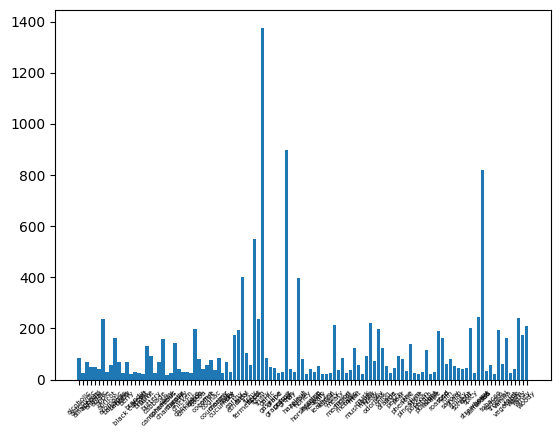

In [7]:
# barplot and rotate the x-axis labels
fig, ax = plt.subplots()
ax.bar(label_count.index, label_count["Count"]) 
plt.xticks(rotation=45, fontsize = 5)

plt.show()

In [8]:
# we see a class imbalance in the labeled data
# we cant see the x-axis labels clearly, so look at the head and tail of the ordered df to determine which labels have the highest and lowest counts
label_count.sort_values('Count', ascending = False)

,Count
fruity,1377
green,896
sweet,821
floral,551
fatty,403
...,...
leathery,20
horseradish,20
musk,20
radish,20


In [9]:
# results head tail label count
#               Count
# fruity        1377
# green         896
# sweet         821
# floral        551
# fatty         403

# leathery      20
# horseradish   20
# musk          20
# radish        20
# catty         17

In [10]:
# Now if we would look at the count of odor descriptions per CID (e.g. per compound)
compound_count = pd.DataFrame(labels_.sum(1))
compound_count.columns = ['Count']
# compound_count

In [11]:
# to big to plot, so we will look at the head and tail of the ordered df to determine which CIDs have the highest and lowest counts
compound_count.sort_values('Count', ascending = False)
# compound_count.sort_values('Count', ascending = False).head(10)
# compound_count.sort_values('Count', ascending = False).tail(10)


,Count
CID,
95594,9
43263,9
605629,9
101363,9
5463910,9
...,...
97883,1
95568,1
94378,1


In [12]:
# we see that the compounds with CID "31260", "121667", and "3776" have a count of zero and thus no odor descriptions
# we could remove these compounds from the dataset since we dont know if the odor of these sturctures is just not available or if it is something else.

c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 47'. Pick better value with 'binwidth'.


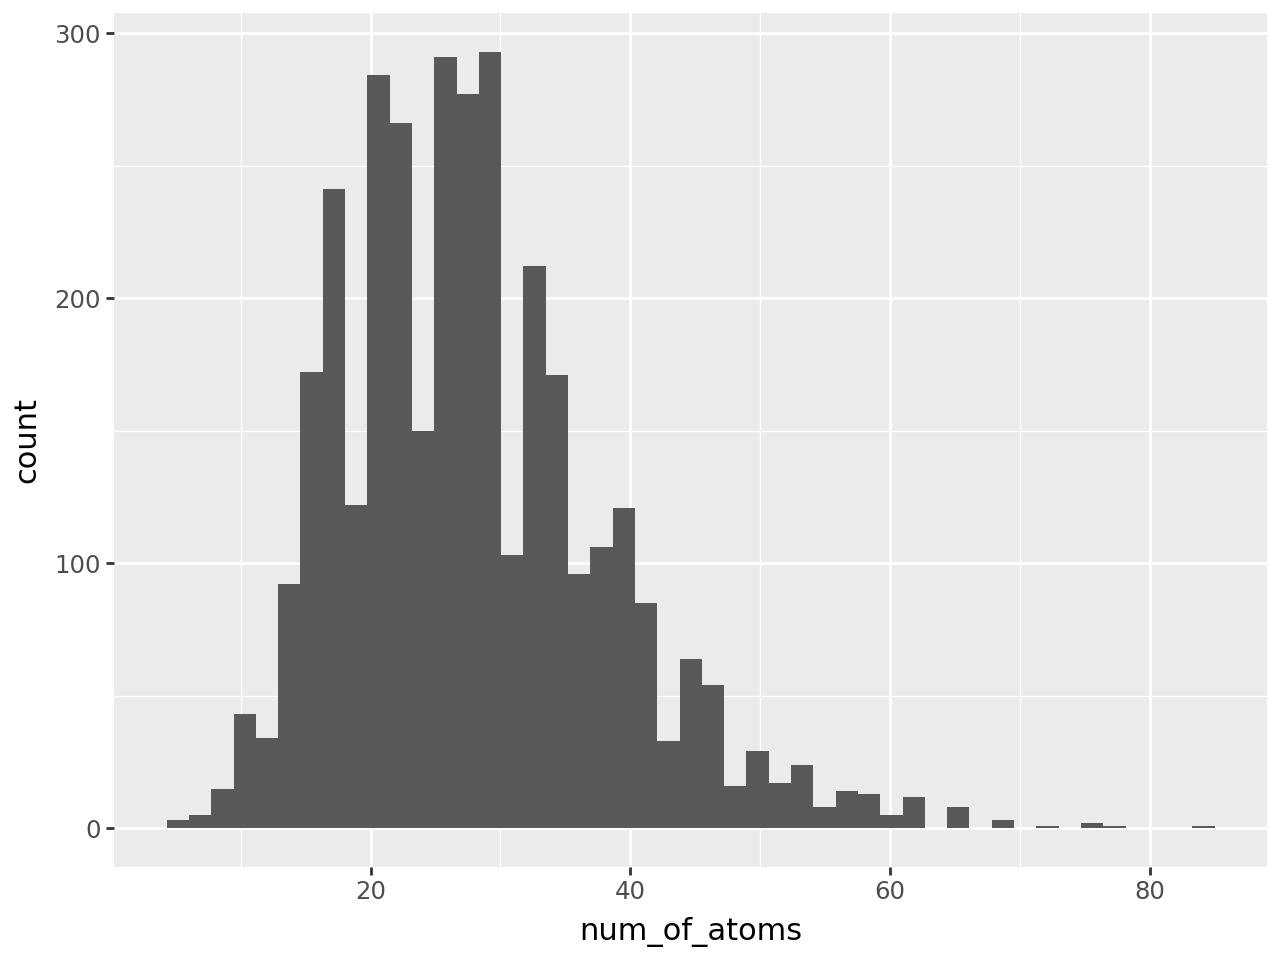

In [13]:
# what else would we want to represent a count from??
# example
ggplot(odorants, aes('num_of_atoms')) + \
    geom_histogram()

In [14]:
# check correlation between every numerical variable in odorants dataset (numerical cause name and smiles dont really contribute maybe? and cant get corr of num-categorical)
num_vars = odorants.select_dtypes(include = ['float64', 'int64'])
num_vars.loc[:, "MolecularWeight":].corr()


,MolecularWeight,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,PolarA,PolarB,TopoCharge,VdW,AromaticA,AromaticB,HBondAcceptorCount,HBondDonorCount,XLogP,TPSA
MolecularWeight,1.000000,0.913047,0.978150,0.923869,0.380665,-0.133188,0.951593,0.866679,-0.102324,0.959450,0.102252,0.101602,0.294155,0.294207,0.294049,0.294272
num_of_atoms,0.913047,1.000000,0.916925,0.935289,0.249481,-0.197838,0.988317,0.972421,-0.129744,0.983916,-0.153663,-0.153624,0.267893,0.270425,0.272957,0.270539
num_of_heavy_atoms,0.978150,0.916925,1.000000,0.966465,0.407493,-0.118332,0.946429,0.840868,-0.083249,0.956250,0.164689,0.164057,0.263148,0.263810,0.264555,0.263905
num_of_C_atoms,0.923869,0.935289,0.966465,1.000000,0.221457,-0.159466,0.959810,0.843742,-0.111864,0.952539,0.137907,0.137802,0.247649,0.252329,0.256950,0.252439
num_of_O_atoms,0.380665,0.249481,0.407493,0.221457,1.000000,-0.291541,0.213364,0.245602,0.144802,0.300273,-0.002377,-0.006213,0.057040,0.044769,0.033126,0.044657
num_of_N_atoms,-0.133188,-0.197838,-0.118332,-0.159466,-0.291541,1.000000,-0.172457,-0.203234,-0.018996,-0.203173,0.319394,0.323660,-0.062957,-0.067689,-0.070541,-0.067308
PolarA,0.951593,0.988317,0.946429,0.959810,0.213364,-0.172457,1.000000,0.948296,-0.138202,0.991670,-0.052387,-0.052316,0.283537,0.286761,0.289805,0.286865
PolarB,0.866679,0.972421,0.840868,0.843742,0.245602,-0.203234,0.948296,1.000000,-0.141570,0.943326,-0.278511,-0.278453,0.282392,0.286357,0.289052,0.286371
TopoCharge,-0.102324,-0.129744,-0.083249,-0.111864,0.144802,-0.018996,-0.138202,-0.141570,1.000000,-0.134384,-0.077875,-0.078161,-0.033601,-0.040153,-0.047782,-0.040151
VdW,0.959450,0.983916,0.956250,0.952539,0.300273,-0.203173,0.991670,0.943326,-0.134384,1.000000,-0.078551,-0.079217,0.303410,0.305838,0.307470,0.305903


## K-Means clustering

In [15]:
pca = PCA(2)
X = fingerprint
X = pca.fit_transform(labels_)
explained_var = pca.explained_variance_ratio_
m = KMeans(n_clusters = 6, random_state = 12345).fit(X) 
m.labels_
X_data = pd.DataFrame(X)
X_data["_clusters"] = pd.Categorical(m.labels_)

explained_var.sum()


0.1590223001325436

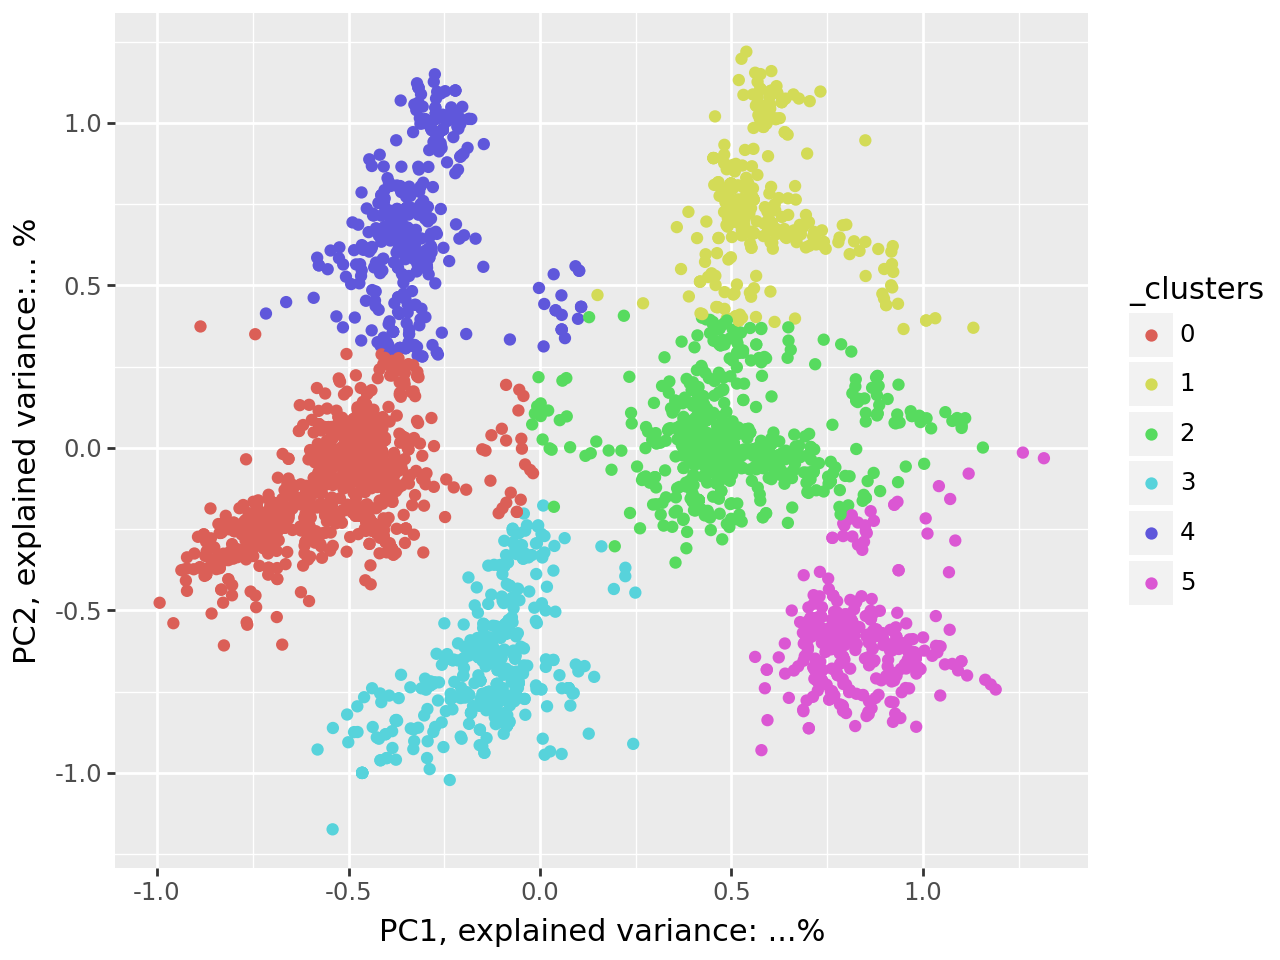

In [16]:
ggplot(X_data, aes(X_data.loc[:, 0], X_data.loc[:, 1], color = "_clusters")) +\
geom_point() +\
xlab("PC1, explained variance: ...%") +\
ylab("PC2, explained variance:... %")

In [17]:
# clean up the image and de clusterdata
# see the labels tha exist in each cluster
# also try hierachical clustering

## Manual Clustering

I went over the odours to manually to make a 'conceptual' clustering of the odour labels. The goal of this is to hopefully alleviate the current class imbalance problem.

I 'found' the following 9 clusters: 
- Fruity
- Sweet
- Green and leafy:
- Earthy
- Savoury
- Spices / Herbs
- Artificial/Chemical
- Sharp
- General

Based on this, I ran a PCA do reduce dimensionality and a k-means clustering with k = 9.
I decided on 3 PCs to see if a third PC would make it easier to separate the clusters.

In [19]:
# Import libraries for 3d plotting and interactivity
import ipympl
%matplotlib widget
from mpl_toolkits import mplot3d

In [20]:
# Doing PCA with 3 PCs
pca = PCA(3)
label_3pc = pca.fit_transform(labels_)
exp_var = pca.explained_variance_ratio_
total_exp_var = exp_var.sum()

df_pc3_labels = pd.DataFrame(label_3pc)

# Doing k-means clustering
cluster9 = KMeans(n_clusters = 9, random_state = 12345).fit(label_3pc) 
cluster9.labels_
df_pc3_labels["_clusters"] = pd.Categorical(cluster9.labels_)

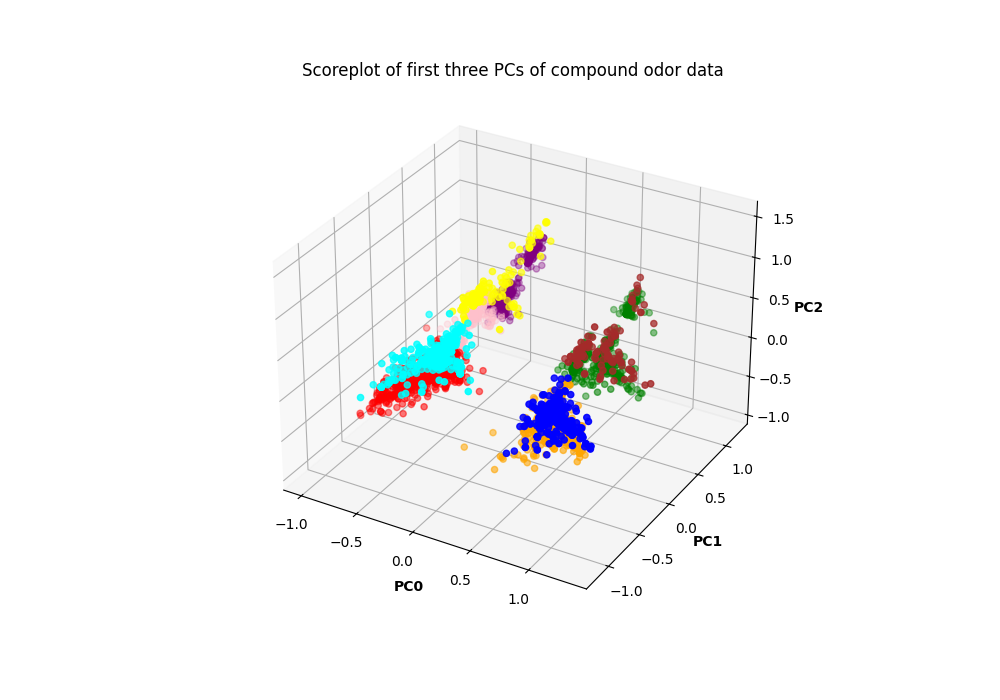

In [22]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
colors = {0:"red",1:"blue",2:"green",3:"yellow",4:"orange",5:"pink",6:"purple",7:"cyan",8:"brown"}
ax.scatter3D(df_pc3_labels[0], df_pc3_labels[1], df_pc3_labels[2], c = df_pc3_labels["_clusters"].map(colors))
plt.title("Scoreplot of first three PCs of compound odor data")
ax.set_xlabel("PC0", fontweight = "bold")
ax.set_ylabel("PC1", fontweight = "bold")
ax.set_zlabel("PC2", fontweight = "bold")
 
# show plot
plt.show()